Pairwise Training:

    Train the model on pairs of teams. For each game, 
you can have a binary outcome: either Team A wins or Team B wins. This can help the model learn the matchups more explicitly.


Index(['TEAM_ID', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away',
       'TEAM_ID_OPP', 'MATCHUP_ID', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%',
       'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF',
       'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY',
       'WL_encoded'],
      dtype='object')


C:\Users\ghadf\AppData\Local\Temp\ipykernel_19496\3076784499.py:44: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = preprocessor_data.corr()


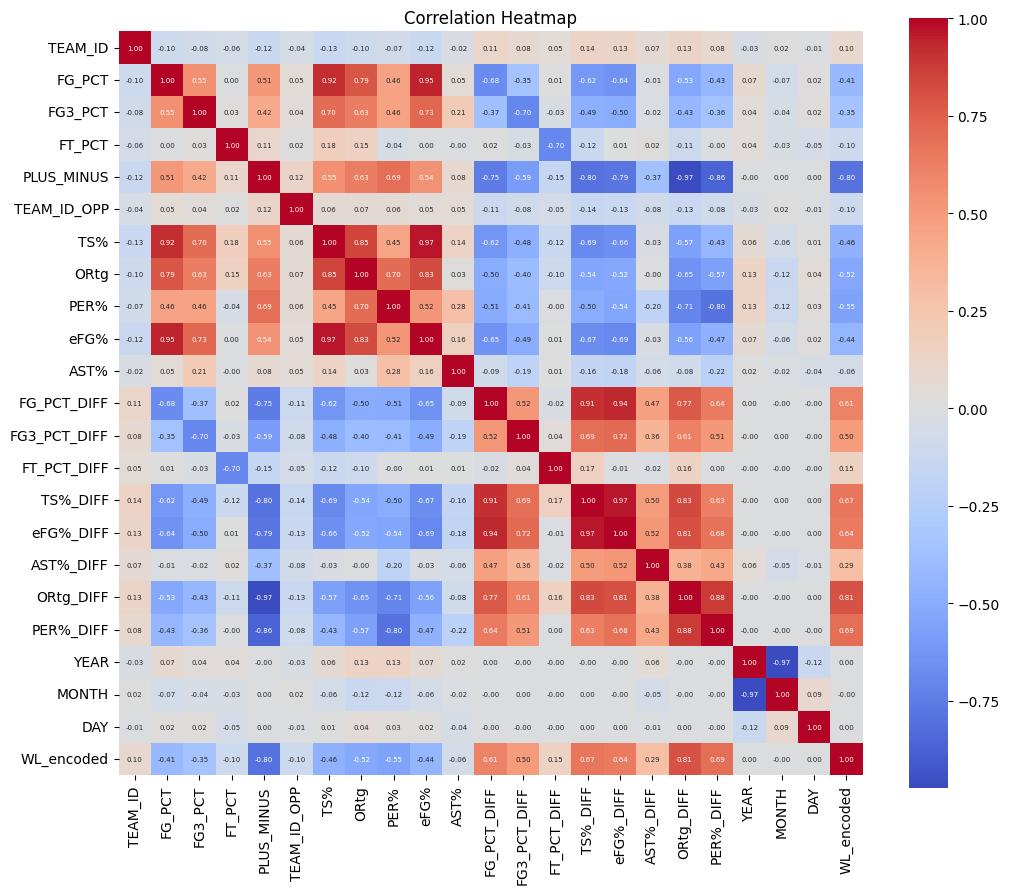

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import preprocessing
# Load the data
data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_prepreprocess_data.csv')


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
preprocessor_data = data[[col for col in data.columns if col != 'WL'] + ['WL']]

#drop the columns that are not needed
x_excluded_independent_variables = ['GAME_DATE', 'TEAM_ABBREVIATION', 'WL', 'FGA', 'TOV', 'TEAM_NAME', 'GAME_ID', 'PPM', 'RPM', 'APM', 'SPM', 'BPM', 'TPM',
                                    'PER', 'OPM', 'DPM', 'USG%', 'FG3A', 'OREB', 'PF', 'MIN', 'PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 
                                    'AST', 'PF', 'STL', 'BLK', 'DREB', 'Offensive_Possessions', 'SEASON_ID', 'MATCHUP', #, 
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP', 'SEASON_ID_OPP', 'Home_Away_OPP' #,  'Defensive_Possessions'
                                    , 'TEAM_NAME_OPP', 'WL_OPP', 'MIN_OPP', 'PF_OPP', 'DREB_OPP'] #, 'TEAM_ID_OPP'

#drop the columns that are not needed
preprocessor_data = preprocessor_data.drop(x_excluded_independent_variables, axis=1)
print(preprocessor_data.columns)

# Create a correlation matrix for the selected columns
correlation_matrix = preprocessor_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

In [2]:
##UPDATE: because they are identification for the season and team, I would like to update my preprocessor so the variable is updated to ordinal vs non ordinal categorical variables 

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'


# Combine y_column with x_excluded_independent_variables
columns_to_drop = [y_column] #+ x_excluded_independent_variables

# Define feature lists
categorical_features = [ 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID'] #'SEASON_ID', 'MATCHUP'
numerical_features = [col for col in preprocessor_data.columns if col not in categorical_features + columns_to_drop]
#numerical features being: TS%, eFG%, APM, OPM, DPM, RPM, BPM, TPM, PER%, PER, ORtg, Plus_minus, fg3_pct, fg_pct, ftm, pts

# Function to label encode categorical columns for tree-based models
def label_encode_data(data, columns_to_encode):
    labelEncoder = preprocessing.LabelEncoder()
    mapping_dict = {}
    for col in columns_to_encode:
        data[col] = labelEncoder.fit_transform(data[col])
        le_name_mapping = dict(zip(labelEncoder.classes_,
                                   labelEncoder.transform(labelEncoder.classes_)))
        mapping_dict[col] = le_name_mapping
    return data, mapping_dict

# Label encode categorical features
#data, mapping_dict = label_encode_data(data, categorical_features)
#print(mapping_dict)

# Use OrdinalEncoder for the categorical columns
ordinal_encoder = OrdinalEncoder()
#preprocessor_data[categorical_features] = ordinal_encoder.fit_transform(preprocessor_data[categorical_features])

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(preprocessor_data[categorical_features])

# Transform the first dataset using the fitted encoder in a separate variable
all_encoded = preprocessor_data
all_encoded[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
# Convert all_encoded to a pandas DataFrame
all_encoded = pd.DataFrame(all_encoded)
#print(all_encoded.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())


# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    #,('onehot', OneHotEncoder(handle_unknown='ignore')) # Use OneHotEncoder for non-tree-based models
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = all_encoded.drop(columns=columns_to_drop, axis=1)
print('before preprocessing = ', X.shape)
print(X.head())
y = all_encoded[y_column]
print('y shape = ', y.shape)
# view unique values in the target variable
print(y.unique())

# Use LabelEncoder to encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#print(X.isnull().sum())
#print(X.dtypes)
# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
print('after preprocessing = ', X_preprocessed.shape)
#print X_preprocessed to see what it looks like
#print(X_preprocessed)

tmp_num = numerical_transformer.fit_transform(X[numerical_features])
print(pd.DataFrame(tmp_num, columns=numerical_features).isnull().sum())

tmp_cat = categorical_transformer.fit_transform(X[categorical_features])
print(pd.DataFrame(tmp_cat).isnull().sum())


before preprocessing =  (2768, 24)
   TEAM_ID  FG_PCT  FG3_PCT  FT_PCT  PLUS_MINUS  Home_Away  TEAM_ID_OPP  \
0     12.0   0.430    0.351   0.714        -5.0        1.0         26.0   
1     26.0   0.494    0.357   0.724         5.0        0.0         12.0   
2     27.0   0.353    0.242   0.900        -9.0        0.0          7.0   
3      7.0   0.458    0.410   0.667         9.0        1.0         27.0   
4     29.0   0.347    0.152   0.643       -41.0        0.0          1.0   

   MATCHUP_ID       TS%        ORtg        PER%      eFG%      AST%  \
0       316.0  0.535489  100.750691  110.628210  0.505814  0.594595   
1       316.0  0.596034  105.149371  107.114780  0.558442  0.657895   
2       244.0  0.483707   92.954990   99.804305  0.400000  0.766667   
3       244.0  0.571931  102.040816  116.758242  0.554217  0.763158   
4        57.0  0.410342   84.300218   88.832487  0.371287  0.371429   

   FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  \
0     0.06

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert the numpy arrays back to pandas DataFrames
feature_names = preprocessor.transformers_[0][-1] + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


# Fit the preprocessor first
preprocessor.fit(X_train)

# Now access the named transformers after fitting
#ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
#all_feature_names = np.concatenate([numerical_features, ohe_feature_names])


#print('Original number of features:', len(numerical_features + categorical_features))
#print('Number of features after one-hot encoding:', len(all_feature_names))
#print(ohe_feature_names)
#print(all_feature_names)




ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS',
                                  'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%',
                                  'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF',
                                  'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF',
                                  'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH',
                                  'DAY']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['TEAM_ID', 'TEAM_ID_OPP', 'Home_Away',
                                  'MATCHUP_ID'])])

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from joblib import dump, load
import os

# Define the path to the directory where you want to save the models
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
# Define a function to save the models
def save_model(model, name):
    path = os.path.join(MODEL_DIR, f"{name.replace(' ', '_').lower()}.joblib")
    dump(model, path)
    return path


# Count the classes
class_counts = np.bincount(y_encoded)
# Calculate the scale_pos_weight for XGBoost
scale_pos_weight = float(class_counts[0] / class_counts[1])

# Note: Some models have hyperparameters set to avoid potential issues. 
# You should adjust these based on understanding and dataset specifics.

#Bin-classification models
#models = [
#    ("Logistic Regression", LogisticRegression(max_iter=10000)),
#    ("Ridge Classifier", RidgeClassifier()), 
#    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
#    ("Decision Tree", DecisionTreeClassifier()), 
#    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
#    ("Gradient Boosting", GradientBoostingClassifier()),
#    ("AdaBoost", AdaBoostClassifier()),
#    ("SVM", SVC()),
#    ("Gaussian Naive Bayes", GaussianNB()),
#    ("K-Neighbors Classifier", KNeighborsClassifier()),
#    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)), # Adjusted for imbalance
#    ("MLP Classifier", MLPClassifier(max_iter=1000))
#]

num_classes = len(np.unique(y_encoded))

#Multi-classification models
models = [
    ("Logistic Regression", LogisticRegression(multi_class='ovr', max_iter=10000)),
    ("Ridge Classifier", RidgeClassifier()), 
    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
    ("Decision Tree", DecisionTreeClassifier()), 
    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier(algorithm='SAMME')),
    ("SVM", SVC(probability=True)), # Added probability=True for decision boundary plotting
    ("Gaussian Naive Bayes", GaussianNB()),
    ("K-Neighbors Classifier", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, 
                              eval_metric="mlogloss", 
                              objective="multi:softprob", 
                              num_class=num_classes)), 
    ("MLP Classifier", MLPClassifier(max_iter=1000))
]


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


def display_confusion_matrix(classifier, X_test, y_test):
    matrix = confusion_matrix(y_test, classifier.predict(X_test), labels=classifier.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d",
                xticklabels=classifier.classes_,
                yticklabels=classifier.classes_, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

from sklearn.decomposition import PCA

from sklearn.base import clone

# Continue using your PCA as before
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train models, plot decision boundaries, and display confusion matrices
results = []
for name, model in models:
    model.fit(X_train, y_train)  # Training on original data
    y_pred = model.predict(X_test)  # Predicting on original data
    
    # Save the trained model
    saved_path = save_model(model, name)
    print(f"Model {name} saved to {saved_path}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    
    # Display classification report
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:")
    print(report)
    
    # Display confusion matrix (using the original X_test)
    display_confusion_matrix(model, X_test, y_test)  
    
    # Now for the decision boundary, we need to train the model again on PCA data.
    # Clone the model to avoid refitting the original one
    model_clone = clone(model)
    model_clone.fit(X_train_pca, y_train)
    
    # Plot decision boundaries using the model trained on PCA data
    #plt.figure(figsize=(10,6))
    #plot_decision_boundary(lambda x: model_clone.predict(x), X_train_pca, y_train)
    #plt.title(name)
    #plt.show()
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("--------------------------------------------------")



IndentationError: unexpected indent (180570065.py, line 143)

In [ ]:
#read "unseen" data so we can test what these models would predict for the 2022 playoffs
#prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv')
prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

print(prediction_data.head())

# Drop the columns that are not needed Matchup
#prediction_data = prediction_data.drop(columns=['MATCHUP'])

    
# Define the desired feature order
#feature_order = ['TEAM_ID', 'MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'FG_PCT_OPP', 'FG3_PCT_OPP', 
                  #'FT_PCT_OPP', 'PLUS_MINUS_OPP', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 
                 #'DRtg', 'DPER%', 'YEAR', 'MONTH', 'DAY',
                 #'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF'] #, 'MATCHUP'

feature_order = ['TEAM_ID', 'TEAM_ID_OPP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'MATCHUP_ID',# 'FG_PCT_OPP', 'FG3_PCT_OPP',  'SEASON_ID', 'GAME_ID'
                   'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', #'FT_PCT_OPP', 'PLUS_MINUS_OPP','TS%_OPP', 'eFG%_OPP', 'AST%_OPP', , 'MATCHUP'
                  'YEAR', 'MONTH', 'DAY', #'DRtg', 'DPER%',
                 'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF'] #, 'MATCHUP'


# Reorder columns in the new_data DataFrame
prediction_data = prediction_data[feature_order]
print(prediction_data.head())

  Home_Away  WL_encoded     TEAM_ID  TEAM_ID_OPP  YEAR  MONTH  DAY MATCHUP_ID  \
0      Away         NaN  1610612756   1610612744  2023     10   24     GSWPHX   
1      Home         NaN  1610612744   1610612756  2023     10   24     GSWPHX   
2      Away         NaN  1610612747   1610612743  2023     10   24     DENLAL   
3      Home         NaN  1610612743   1610612747  2023     10   24     DENLAL   
4      Away         NaN  1610612757   1610612746  2023     10   25     LACPOR   

   PLUS_MINUS    FG_PCT   FG3_PCT    FT_PCT       TS%      eFG%       AST%  \
0   -1.125000  0.462793  0.358759  0.797852  0.562174  0.526527  29.650896   
1    7.745098  0.475678  0.386994  0.768642  0.594860  0.567262  33.254412   
2   -3.509804  0.476464  0.335669  0.789947  0.576345  0.534696  28.000000   
3    9.229630  0.504385  0.384390  0.740941  0.603544  0.574439  32.962567   
4   -5.613636  0.465647  0.355495  0.777070  0.575832  0.535963  28.260870   

         ORtg        PER%  FG_PCT_DIFF  FG3_

In [ ]:
#############################################################################################################


# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])

# Transform the categorical columns in dataset1 using the fitted encoder
#print(data.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())

print(prediction_data.head())
# Use OrdinalEncoder for the categorical columns
prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])
print(prediction_data.head())

# Check if the categorical columns in dataset1 and dataset2 are the same
if set(prediction_data[categorical_features]) != set(preprocessor_data[categorical_features]):
    raise ValueError("Categorical columns in dataset1 do not match dataset2")



      TEAM_ID  TEAM_ID_OPP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  \
0  1610612756   1610612744  0.462793  0.358759  0.797852   -1.125000   
1  1610612744   1610612756  0.475678  0.386994  0.768642    7.745098   
2  1610612747   1610612743  0.476464  0.335669  0.789947   -3.509804   
3  1610612743   1610612747  0.504385  0.384390  0.740941    9.229630   
4  1610612757   1610612746  0.465647  0.355495  0.777070   -5.613636   

  Home_Away MATCHUP_ID       TS%        ORtg        PER%      eFG%       AST%  \
0      Away     GSWPHX  0.562174  111.621718  122.903735  0.526527  29.650896   
1      Home     GSWPHX  0.594860  114.725678  128.606069  0.567262  33.254412   
2      Away     DENLAL  0.576345  110.741055  114.875990  0.534696  28.000000   
3      Home     DENLAL  0.603544  117.680293  128.905640  0.574439  32.962567   
4      Away     LACPOR  0.575832  110.343321  113.347718  0.535963  28.260870   

   YEAR  MONTH  DAY  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  \
0  2023

In [ ]:
#check for these team_id's in the prediction_data [1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
prediction_teams = prediction_data['TEAM_ID'].unique()
print(prediction_teams)

# Fit the encoder on the first dataset's categorical columns
#ordinal_encoder.fit(preprocessor_data[categorical_features])

# Use OrdinalEncoder for the categorical columns
#prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])

print(prediction_data.head())



[19.  7. 10.  6. 20.  9.  8.  1. 27.  0. 16. 15. 17. 29. 28. 13.  2. 11.
 24. 14.  3. 23. 26.  4. 21. 25.  5. 22.]
   TEAM_ID  TEAM_ID_OPP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  Home_Away  \
0     19.0          7.0  0.462793  0.358759  0.797852   -1.125000        0.0   
1      7.0         19.0  0.475678  0.386994  0.768642    7.745098        1.0   
2     10.0          6.0  0.476464  0.335669  0.789947   -3.509804        0.0   
3      6.0         10.0  0.504385  0.384390  0.740941    9.229630        1.0   
4     20.0          9.0  0.465647  0.355495  0.777070   -5.613636        0.0   

   MATCHUP_ID       TS%        ORtg        PER%      eFG%       AST%  YEAR  \
0       238.0  0.562174  111.621718  122.903735  0.526527  29.650896  2023   
1       238.0  0.594860  114.725678  128.606069  0.567262  33.254412  2023   
2       187.0  0.576345  110.741055  114.875990  0.534696  28.000000  2023   
3       187.0  0.603544  117.680293  128.905640  0.574439  32.962567  2023   
4       293.0 

In [ ]:
# Preprocess X_new
X_new_preprocessed = preprocessor.transform(prediction_data)
print(X_new_preprocessed.shape)
#print(X_new_preprocessed)
X_unseen_preprocessed = pd.DataFrame(X_new_preprocessed, columns=feature_names)
print(X_unseen_preprocessed.head())


(28, 24)
     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS       TS%        ORtg        PER%  \
0  0.464944  0.364521  0.807570   -1.128410  0.561235  110.796896  124.044966   
1  0.477655  0.392840  0.777937    7.785749  0.593496  113.877666  129.799504   
2  0.478430  0.341363  0.799551   -3.525060  0.575221  109.922813  115.943728   
3  0.505974  0.390228  0.749833    9.277655  0.602066  116.810206  130.101818   
4  0.467759  0.361248  0.786487   -5.639343  0.574715  109.528050  114.401466   

       eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  \
0  0.532715  29.854276     0.008424     -0.010421    -0.011955  0.019198   
1  0.573037  33.480968    -0.028219     -0.070556     0.001158 -0.046397   
2  0.540801  28.192762    -0.002136      0.013675    -0.006764 -0.000915   
3  0.580140  33.187245    -0.047117     -0.069793     0.053277 -0.046800   
4  0.542055  28.455310     0.017336     -0.004310     0.008230  0.015409   

   eFG%_DIFF  AST%_DIFF  ORtg_DIFF  PER%_DIFF  

In [ ]:
# Load the trained Random Forest model
xgboost = os.path.join(MODEL_DIR, "xgboost.joblib")
trained_rf = load(xgboost)

# Predict using the trained model
predictions_rf = trained_rf.predict(X_unseen_preprocessed)

# Convert predictions back from encoded form to original labels
decoded_predictions_rf = label_encoder.inverse_transform(predictions_rf)

# Add predictions as a new column to the original dataframe
prediction_data['PREDICTION'] = decoded_predictions_rf

# Inverse transform the encoded categorical columns back to their original form
prediction_data[categorical_features] = ordinal_encoder.inverse_transform(prediction_data[categorical_features])

# Display the results with the original values
#print(prediction_data.head())

# put YEAR, MONTH, DAY into a date column
prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
#sort by date
prediction_data = prediction_data.sort_values(by=['Date'])
print(prediction_data.head())

       TEAM_ID TEAM_ID_OPP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  \
0   1610612756  1610612744  0.462793  0.358759  0.797852   -1.125000   
1   1610612744  1610612756  0.475678  0.386994  0.768642    7.745098   
2   1610612747  1610612743  0.476464  0.335669  0.789947   -3.509804   
3   1610612743  1610612747  0.504385  0.384390  0.740941    9.229630   
25  1610612762  1610612758  0.468235  0.357186  0.771277    0.534884   

   Home_Away MATCHUP_ID       TS%        ORtg        PER%      eFG%  \
0       Away     GSWPHX  0.562174  111.621718  122.903735  0.526527   
1       Home     GSWPHX  0.594860  114.725678  128.606069  0.567262   
2       Away     DENLAL  0.576345  110.741055  114.875990  0.534696   
3       Home     DENLAL  0.603544  117.680293  128.905640  0.574439   
25      Home     SACUTA  0.583271  113.044141  119.816474  0.545229   

         AST%  YEAR  MONTH  DAY  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  \
0   29.650896  2023     10   24     0.009186      0.001317    -0.

In [ ]:
# Assuming you've already read in your df1
df1 = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')

# Filter df1 to only unique TEAM_ID, TEAM_NAME, and SEASON_ID
unique_teams = df1[['TEAM_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION']].drop_duplicates()

# Merge unique_teams with prediction_data
prediction_data = prediction_data.merge(unique_teams, on='TEAM_ID', how='left')
#print(prediction_data.head())
#print(len(prediction_data))

# Drop unnecessary columns
columns_to_drop = ["TEAM_ID", "TEAM_ID_OPP", "YEAR", "MONTH", "DAY"]
prediction_data = prediction_data.drop(columns=columns_to_drop)  # using errors='ignore' to avoid any error if columns are not present


# print this list:
season_pred = prediction_data#[['TEAM_NAME', 'TEAM_ABBREVIATION', 'PREDICTION', 'Date', 'MATCHUP_ID', 'Home_Away']]
print(season_pred.head())

#save this to a csv
season_pred.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\season_pred.csv', index=False)

     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS Home_Away MATCHUP_ID       TS%  \
0  0.462793  0.358759  0.797852   -1.125000      Away     GSWPHX  0.562174   
1  0.475678  0.386994  0.768642    7.745098      Home     GSWPHX  0.594860   
2  0.476464  0.335669  0.789947   -3.509804      Away     DENLAL  0.576345   
3  0.504385  0.384390  0.740941    9.229630      Home     DENLAL  0.603544   
4  0.468235  0.357186  0.771277    0.534884      Home     SACUTA  0.583271   

         ORtg        PER%      eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  \
0  111.621718  122.903735  0.526527  29.650896     0.009186      0.001317   
1  114.725678  128.606069  0.567262  33.254412    -0.027732     -0.058677   
2  110.741055  114.875990  0.534696  28.000000    -0.001454      0.025357   
3  117.680293  128.905640  0.574439  32.962567    -0.046772     -0.057916   
4  113.044141  119.816474  0.545229  28.601307    -0.002871     -0.006546   

   FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  PER%_DIFF

In [ ]:
# Combine predictions with team_ids for summarized results
results_by_team = pd.DataFrame({
    'TEAM_NAME': prediction_data['TEAM_NAME'],
    'TEAM_ID': prediction_data['TEAM_ID'],
    'PREDICTION': prediction_data['PREDICTION']
})

# Display results by each team_id
for team_id in results_by_team['TEAM_ID'].unique():
    team_results = results_by_team[results_by_team['TEAM_ID'] == team_id]
    team_name = team_results['TEAM_NAME'].iloc[0]
    print(f"Results for {team_name} (Team ID {team_id}):")
    print(team_results.groupby(['TEAM_NAME', 'PREDICTION']).size().reset_index(name='COUNT'))
    print("-------------------------------")

KeyError: 'TEAM_ID'

In [ ]:
import streamlit as st

# Create a function that returns the trained model based on the selected name
def train_model_by_name(model_selection):
    for name, model in models:
        if name == model_selection:
            model.fit(X_train, y_train)
            return model
    return None

# Create a function to predict using a trained model and display the predictions
def predict_with_model(trained_model):
    predictions_rf = trained_model.predict(X_unseen_preprocessed)
    decoded_predictions_rf = label_encoder.inverse_transform(predictions_rf)
    prediction_data['PREDICTION'] = decoded_predictions_rf
    prediction_data[categorical_features] = ordinal_encoder.inverse_transform(prediction_data[categorical_features])

    season_pred = prediction_data[['TEAM_NAME', 'TEAM_ABBREVIATION', 'PREDICTION', 'Date', 'MATCHUP']]
    return season_pred

# Streamlit app main function
def main():

    st.title('NBA Game Prediction Model Selection')

    # Allow model selection
    model_selection = st.selectbox("Choose a Model:", [name for name, _ in models])

    # Display model training progress
    with st.spinner(f"Training {model_selection}..."):
        trained_model = train_model_by_name(model_selection)
    st.success(f"{model_selection} trained!")

    # Display accuracy on the training data
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    st.write(f"Accuracy of {model_selection} on Training Data: {accuracy:.4f}")

    # Display predictions
    st.header("Predictions for Upcoming Games")
    season_pred_df = predict_with_model(trained_model)
    
    st.write(season_pred_df)

# Ensure the app runs when the script is executed
if __name__ == '__main__':
    main()


ValueError: could not convert string to float: 'Away'

In [ ]:
import streamlit as st
import os
import pandas as pd

# Streamlit app main function
def main():

    st.title('NBA Game Prediction Model Selection')

    # List available models from the directory
    available_models = [f.split('_predictions.csv')[0] for f in os.listdir('models') if f.endswith('_predictions.csv')]

    # Allow model selection
    model_selection = st.selectbox("Choose a Model:", available_models)

    # Load pre-computed predictions for the selected model
    predictions_path = os.path.join('models', f"{model_selection}_predictions.csv")
    predictions_df = pd.read_csv(predictions_path)

    st.header(f"Predictions from {model_selection}")
    st.write(predictions_df)

# Ensure the app runs when the script is executed
if __name__ == '__main__':
    main()
